In [1]:
function [X, omega] = mrw_classic(N, lambda2)
% MRW_CLASSIC  Direct O(N^2) MRW generator (Bacry–Delour–Muzy)

    rng('shuffle');

    % Log‑correlated field
    omega = zeros(N,1);
    for i = 1:N
        s = 0;
        for j = 1:N
            dist = abs(i-j);
            if dist > 0
                s = s + randn() / sqrt(dist + 1);
            end
        end
        omega(i) = sqrt(lambda2) * s / sqrt(N);
    end

    % Center field
    omega = omega - mean(omega);

    % MRW integration
    X = zeros(N,1);
    for i = 2:N
        X(i) = X(i-1) + randn() * exp(omega(i));
    end
end


In [2]:
function [X, omega] = mrw_fft(N, lambda2)
% MRW_FFT  Fast O(N log N) MRW generator using FFT
% Implements Bacry–Delour–Muzy spectral construction

    rng('shuffle');

    % Build positive‑frequency spectrum
    freq = zeros(N/2+1,1);
    for k = 0:(N/2)
        if k == 0
            amp = 0;
        else
            amp = sqrt(lambda2 / k);
        end
        phase = 2*pi*randn();
        freq(k+1) = amp * exp(1i*phase);
    end

    % Hermitian symmetry for real IFFT
    fullSpec = zeros(N,1);
    fullSpec(1:(N/2+1)) = freq;
    fullSpec((N/2+2):N) = conj(freq(end-1:-1:2));

    % Inverse FFT → log‑correlated field
    omega = real(ifft(fullSpec)) / sqrt(N);
    omega = omega - mean(omega);

    % MRW integration
    X = zeros(N,1);
    for i = 2:N
        X(i) = X(i-1) + randn() * exp(omega(i));
    end
end



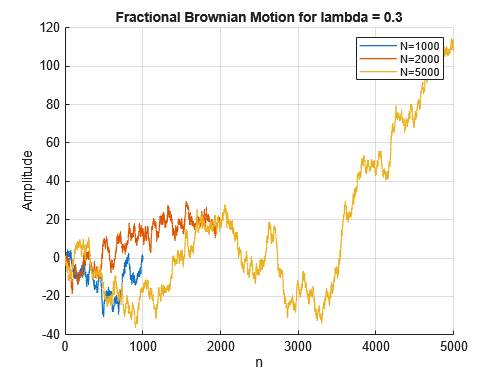


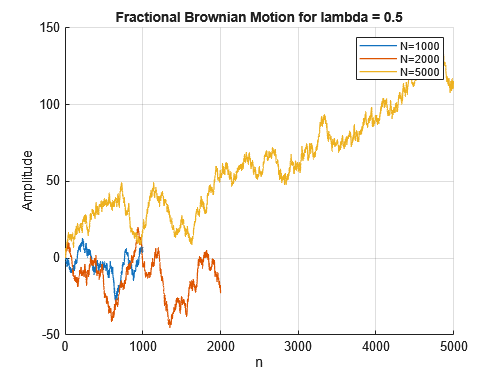

In [3]:
clear; close all; clc;

%% ---------------------------------------------------------
% PARAMETERS
% ---------------------------------------------------------
lambda  = [0.3, 0.5, 0.7];                 % lambda
Nvals  = [1000, 2000, 5000];       % different noise lengths
qvals  = -5:5;                            % q for tau(q)
numH   = numel(lambda);
numN   = numel(Nvals);

colorsN = lines(numN);                    % colors for different N

%% ---------------------------------------------------------
% STORAGE FOR RESULTS
% fbm{hi,ni}        - signal
% dh{hi,ni}, h{hi,ni} - multifractal spectrum
% cp{hi,ni}         - cumulants [C1 C2 C3]
% tauq{hi,ni}       - scaling function tau(q)
% leaders{hi,ni}    - leaders by scale
% structfunc{hi,ni} - structure function info (Tq, weights, logscales)
% ---------------------------------------------------------
fbm        = cell(numH, numN);
dh         = cell(numH, numN);
h          = cell(numH, numN);
cp         = cell(numH, numN);
tauq       = cell(numH, numN);
leaders    = cell(numH, numN);
structfunc = cell(numH, numN);

%% ---------------------------------------------------------
% MAIN LOOP: GENERATE SIGNALS AND RUN DWTLEADER ONCE
% ---------------------------------------------------------
for hi = 1:numH
    l = lambda(hi);
    for ni = 1:numN
        N = Nvals(ni);

        % Generate fBm
        [fbm{hi,ni},omega] = mrw_classic(N,l);

        % Wavelet leader multifractal analysis
        [dh{hi,ni}, h{hi,ni}, cp{hi,ni}, tauq{hi,ni}, ...
            leaders{hi,ni}, structfunc{hi,ni}] = dwtleader(fbm{hi,ni});
    end
end

%% ---------------------------------------------------------
% 1. PLOT FBM SIGNALS (for reference)
% One figure per H, different colors for different N
% ---------------------------------------------------------
for hi = 1:numH
    figure; hold on;
    for ni = 1:numN
        N = Nvals(ni);
        x = 1:N;
        plot(x, fbm{hi,ni}, 'LineWidth', 1.0, 'Color', colorsN(ni,:));
    end
    title("Fractional Brownian Motion for lambda = " + string(lambda(hi)))
    xlabel("n"); ylabel("Amplitude");
    legend("N="+string(Nvals), ...
        "Location","NorthEast")
    grid on
end

<center>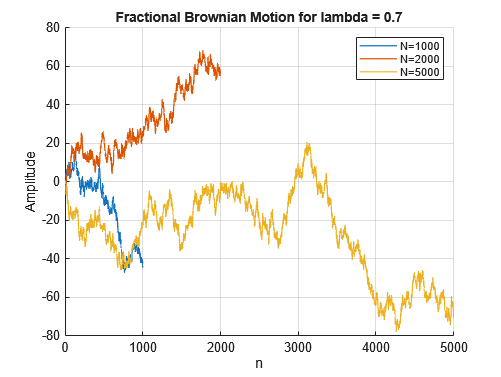</center>




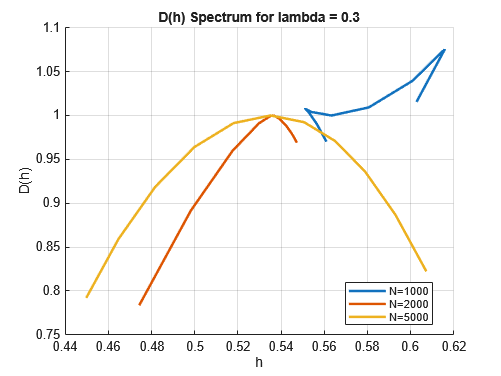


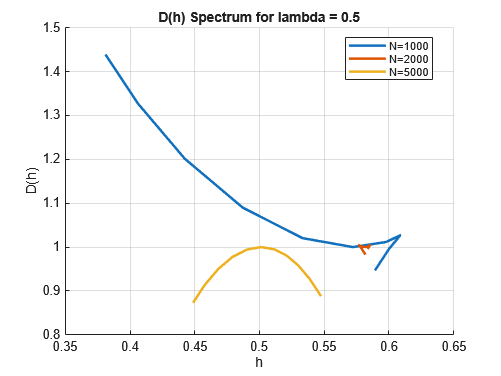

In [4]:

%% ---------------------------------------------------------
% 2. MULTIFRACTAL SPECTRUM D(h) VS NOISE LENGTH (PER H)
% ---------------------------------------------------------
for hi = 1:numH
    figure; hold on;
    for ni = 1:numN
        plot(h{hi,ni}, dh{hi,ni}, 'LineWidth', 2, 'Color', colorsN(ni,:));
    end
    xlabel("h"); ylabel("D(h)")
    title("D(h) Spectrum for lambda = " + string(lambda(hi)))
    legend("N="+string(Nvals), "Location","Best")
    grid on
end

<center>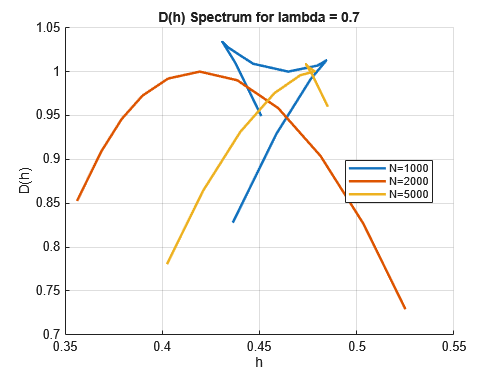</center>




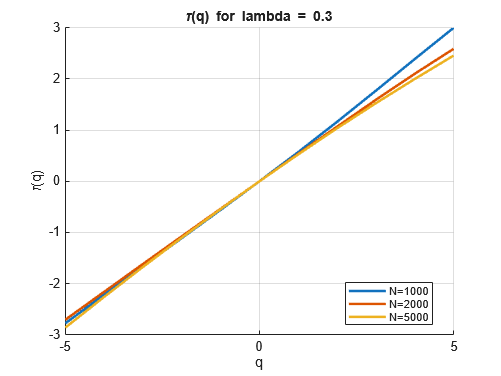


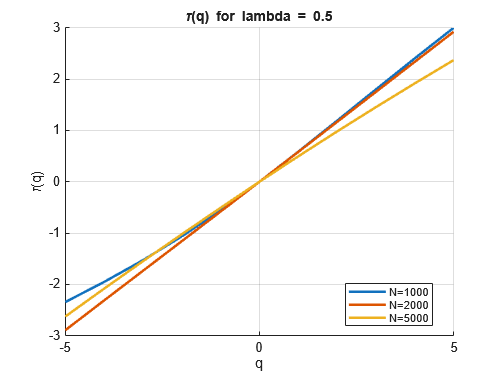

In [5]:

%% ---------------------------------------------------------
% 3. SCALING FUNCTION tau(q) VS NOISE LENGTH (PER H)
% ---------------------------------------------------------
for hi = 1:numH
    figure; hold on;
    for ni = 1:numN
        plot(qvals, tauq{hi,ni}, 'LineWidth', 2, 'Color', colorsN(ni,:));
    end
    xlabel("q"); ylabel("\tau(q)")
    title("\tau(q) for lambda = " + string(lambda(hi)))
    legend("N="+string(Nvals), "Location","Best")
    grid on
end

<center>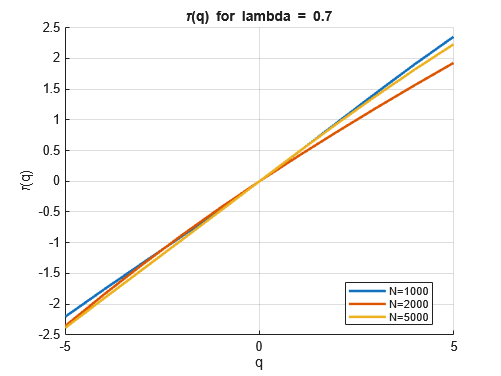</center>




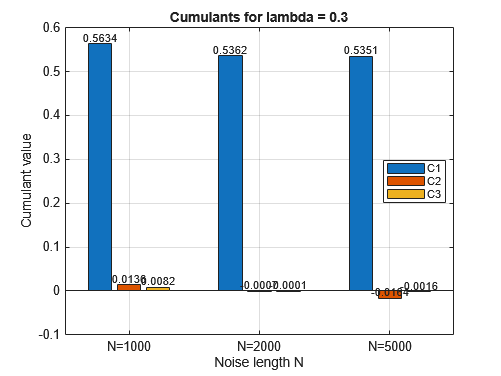


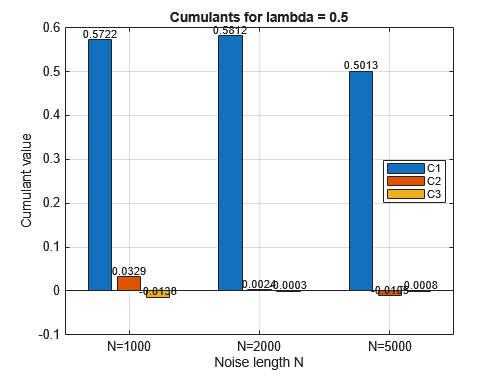

In [6]:

%% ---------------------------------------------------------
% 4. CUMULANTS VS NOISE LENGTH (PER H)
% Reads cp{hi,ni} only
% ---------------------------------------------------------
for hi = 1:numH
    Cmat = zeros(numN, 3);   % rows: N, cols: C1 C2 C3
    for ni = 1:numN
        Cmat(ni,:) = cp{hi,ni};
    end

    figure;
    b = bar(Cmat);
    set(gca, 'XTickLabel', "N="+string(Nvals))
    xlabel("Noise length N")
    ylabel("Cumulant value")
    legend("C1","C2","C3", "Location","Best")
    title("Cumulants for lambda = " + string(lambda(hi)))
    grid on

    % Optional: add labels above bars
    for k = 1:numel(b)
        x = b(k).XEndPoints;
        y = b(k).YEndPoints;
        labels = string(round(b(k).YData, 4));
        text(x, y, labels, ...
            'HorizontalAlignment','center', ...
            'VerticalAlignment','bottom', ...
            'FontSize', 9)
    end
end

<center>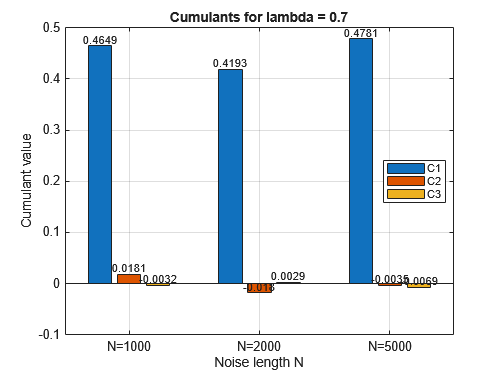</center>




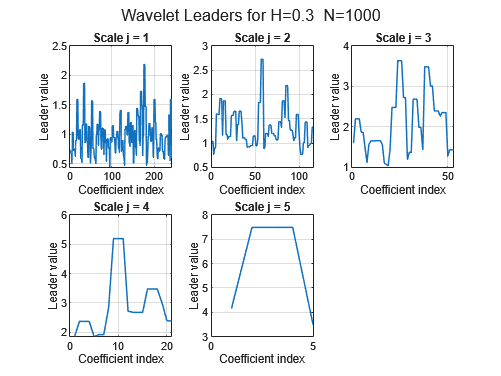


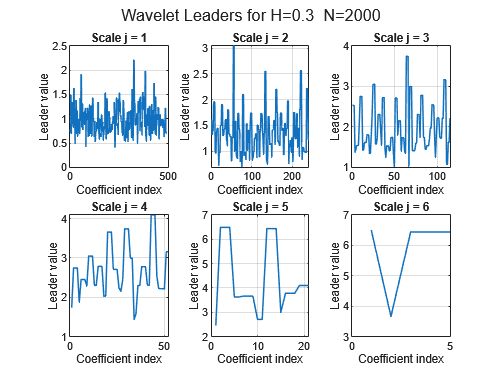

In [7]:

%% ---------------------------------------------------------
% 6. WAVELET LEADERS ACROSS SCALES (PER H, PER N)
% Reads leaders{hi,ni} only
% ---------------------------------------------------------
for hi = 1:numH
    for ni = 1:numN
        L = leaders{hi,ni};          % cell array of scales
        numL = numel(L);
        rows = ceil(numL/3);

        figure;
        for j = 1:numL
            subplot(rows, 3, j)
            plot(L{j}, 'LineWidth', 1.2)
            title("Scale j = " + string(j))
            xlabel("Coefficient index")
            ylabel("Leader value")
            grid on
        end
        sgtitle("Wavelet Leaders for H="+string(lambda(hi))+ ...
                "  N="+string(Nvals(ni)))
    end
end

<center>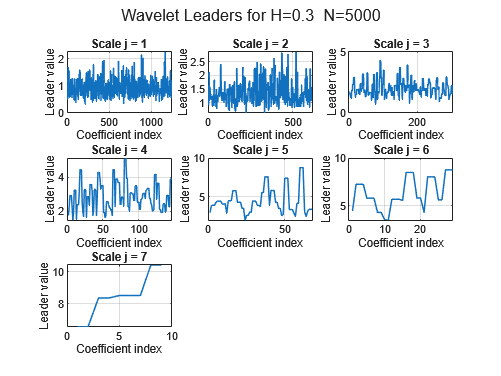</center>


<center>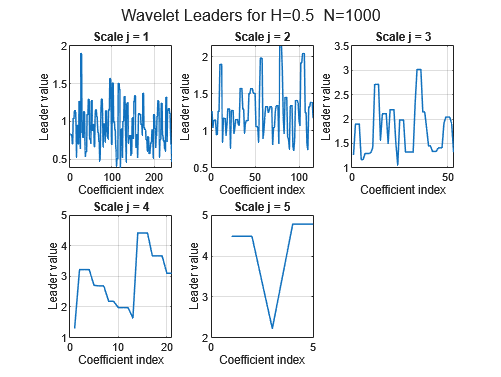</center>


<center>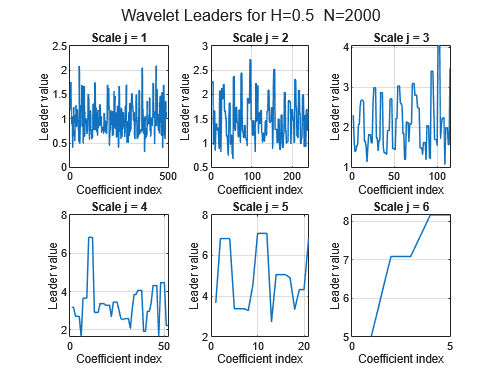</center>


<center>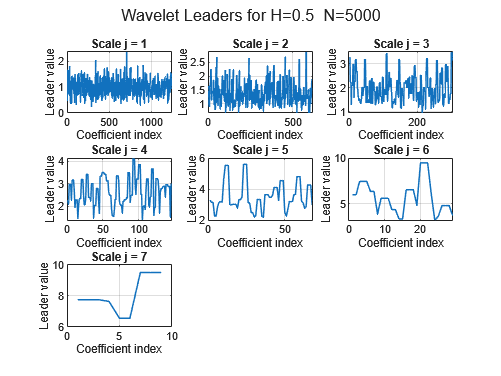</center>


<center>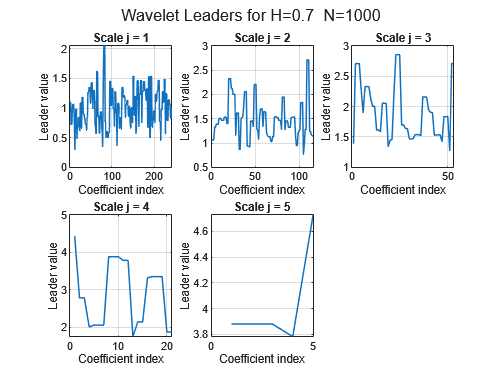</center>


<center>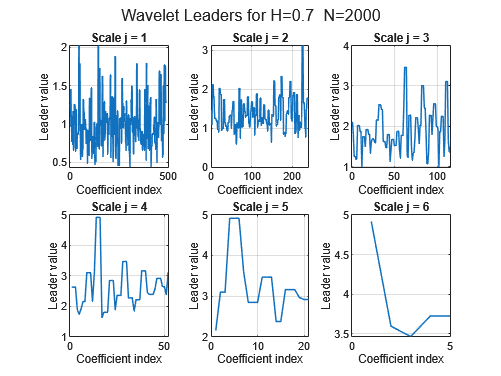</center>


<center>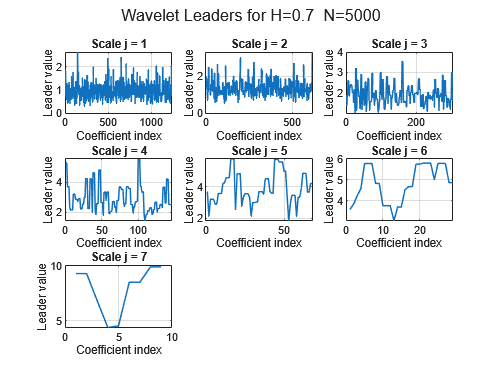</center>



